# Custom PyMC Models in CausalPy

CausalPy provides a flexible modelling layer that can be customized at two levels, depending on what you need to change.

Most customization can be achieved without writing a new model class. The `Prior` system lets you change both parameter priors and the likelihood distribution on any built-in model. When you need to change the model's _structure_ — how the mean function is computed, adding latent variables, or using non-standard parameterizations — you can subclass `PyMCModel` and implement a single `build_model()` method. Your custom model then works with all of CausalPy's experiment classes, plots, and effect summaries out of the box.

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from pymc_extras.prior import Prior

import causalpy as cp
from causalpy.pymc_models import PyMCModel

/Users/benjamv/miniforge3/envs/CausalPy/lib/python3.13/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Level 1: Customization via the Prior system

The built-in models (such as `LinearRegression`) delegate both their parameter priors and their likelihood to the `Prior` class from `pymc_extras`. This means you can change not just the priors on coefficients, but the _entire likelihood distribution_ — all without subclassing.

### Changing parameter priors

Pass a `priors` dictionary when constructing the model to override defaults:

```python
model = cp.pymc_models.LinearRegression(
    priors={
        "beta": Prior("Normal", mu=0, sigma=10, dims=["treated_units", "coeffs"]),
    }
)
```

### Changing the likelihood distribution

The likelihood is controlled by the `"y_hat"` prior. For example, to use a Student-t likelihood for robustness to outliers:

```python
model = cp.pymc_models.LinearRegression(
    priors={
        "y_hat": Prior(
            "StudentT",
            nu=4,
            sigma=Prior("HalfNormal", sigma=1, dims=["treated_units"]),
            dims=["obs_ind", "treated_units"],
        ),
    }
)
```

This works because `LinearRegression.build_model()` calls `self.priors["y_hat"].create_likelihood_variable(...)`, which creates whatever distribution you specify. See the {doc}`../notebooks/its_pymc_comparative` notebook for a complete worked example using a Student-t likelihood.

:::{tip}
Before writing a custom model class, check whether the `Prior` system can already do what you need. Changing priors and likelihoods covers many common use cases.
:::

## Level 2: Subclassing `PyMCModel`

When the `Prior` system is not enough, you can subclass `PyMCModel`. This is required when you want to change:

- **The mean function**: How `mu` is computed from predictors and parameters (e.g., `mu = exp(X @ beta)` instead of `mu = X @ beta`)
- **Latent variables**: Adding hidden variables not in the standard beta/sigma parameterization
- **Custom error structure**: Correlated residuals, heteroscedasticity where sigma depends on covariates
- **Non-standard parameterizations**: Anything beyond what patsy formulas and the Prior system can express

Your custom class needs to implement one method — `build_model(self, X, y, coords)` — and follow the naming conventions described below. Once you do, all CausalPy experiment classes (`InterruptedTimeSeries`, `DifferenceInDifferences`, `SyntheticControl`, etc.) will work with your model, including their plots, effect summaries, and diagnostics.

### The `PyMCModel` contract

CausalPy's machinery (`predict`, `score`, `calculate_impact`, `print_coefficients`) relies on specific variable and dimension names inside your model. If you use different names, you will get `KeyError`s at runtime.

**Required variable names:**

| Component | Required name | Used by |
|-----------|---------------|----------|
| Feature data | `"X"` | `_data_setter()`, `predict()` |
| Outcome data | `"y"` | `_data_setter()` |
| Expected value | `"mu"` | `predict()`, `score()`, `calculate_impact()` |
| Likelihood | `"y_hat"` | `predict()` |
| Coefficients | `"beta"` | `print_coefficients()` |
| Noise scale | `"sigma"` or `"y_hat_sigma"` | `print_coefficients()` |

**Required dimension names:**

| Dimension | Description |
|-----------|-------------|
| `"obs_ind"` | Observation index (rows of X and y) |
| `"coeffs"` | Predictor names (columns of X) |
| `"treated_units"` | Unit names (columns of y) |

:::{important}
All model code must be wrapped in `with self:` so that PyMC registers the variables on the correct model instance.
:::

:::{tip}
You can use `self.priors["..."].create_variable("...")` and `self.priors["..."].create_likelihood_variable("...")` inside your custom model to get the same prior-override capability that the built-in models have. See the example below.
:::

### Example: Log-link regression for positive outcomes

The built-in `LinearRegression` uses an identity link: $\mu = X \beta$. This works well for outcomes that can take any real value, but for inherently positive quantities like revenue or order counts, the counterfactual predictions can become negative — especially during extrapolation.

A log-link model uses $\mu = \exp(X \beta)$, which guarantees positive predictions and gives coefficients a multiplicative interpretation: a unit change in a predictor scales the outcome by $\exp(\beta)$.

The implementation below differs from `LinearRegression` in two ways:
1. The mean function wraps the linear predictor in `pt.exp()`
2. The default prior on `beta` uses `sigma=2` instead of `sigma=50`, since coefficients operate on the log scale where values are typically much smaller

In [3]:
class LogLinearRegression(PyMCModel):
    """Linear regression with a log link function.

    Predictions are constrained to be positive: mu = exp(X @ beta).
    Suitable for positive-valued outcomes such as revenue or order counts.
    """

    default_priors = {
        "beta": Prior("Normal", mu=0, sigma=2, dims=["treated_units", "coeffs"]),
        "y_hat": Prior(
            "Normal",
            sigma=Prior("HalfNormal", sigma=1, dims=["treated_units"]),
            dims=["obs_ind", "treated_units"],
        ),
    }

    def build_model(self, X, y, coords):
        with self:
            if coords is not None and "treated_units" not in coords:
                coords = coords.copy()
                coords["treated_units"] = ["unit_0"]

            self.add_coords(coords)
            X = pm.Data("X", X, dims=["obs_ind", "coeffs"])
            y = pm.Data("y", y, dims=["obs_ind", "treated_units"])
            beta = self.priors["beta"].create_variable("beta")
            mu = pm.Deterministic(
                "mu",
                pt.exp(pt.dot(X, beta.T)),
                dims=["obs_ind", "treated_units"],
            )
            self.priors["y_hat"].create_likelihood_variable("y_hat", mu=mu, observed=y)

## Demonstration: ITS with positive-valued outcomes

We simulate monthly revenue data that follows a multiplicative (log-linear) process, then apply an {term}`Interrupted Time Series` analysis using our custom model.

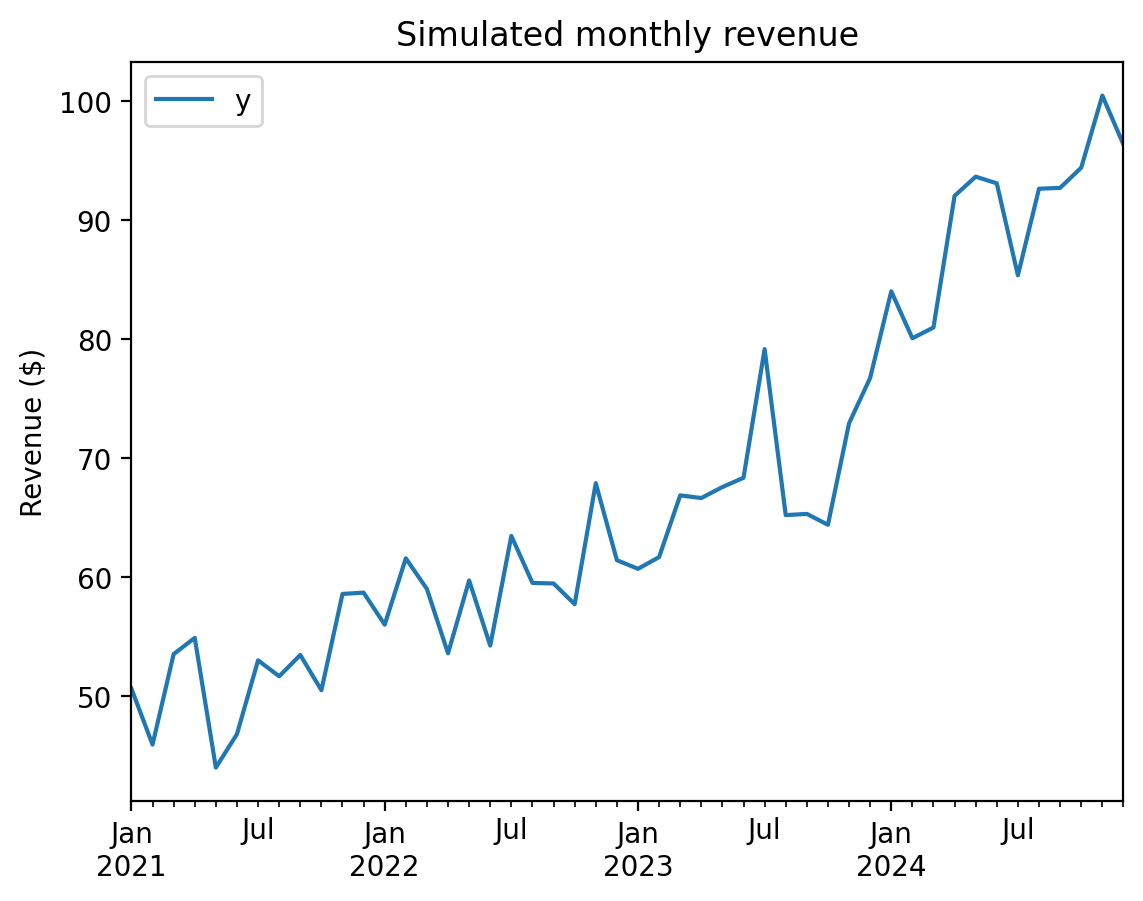

In [4]:
rng = np.random.default_rng(seed)
n_pre, n_post = 36, 12
n = n_pre + n_post

dates = pd.date_range("2021-01-01", periods=n, freq="MS")
t = np.arange(n, dtype=float)

true_intercept = 3.9
true_slope = 0.01
true_effect = 0.18

log_y = true_intercept + true_slope * t + rng.normal(0, 0.08, n)
log_y[n_pre:] += true_effect

df = pd.DataFrame({"t": t, "y": np.exp(log_y)}, index=dates)
treatment_time = pd.Timestamp("2024-01-01")

df.plot(y="y", ylabel="Revenue ($)", title="Simulated monthly revenue");

When using a log-link model, the coefficients operate on the log scale, so feature scaling matters more than with an identity link. We standardize the time predictor to keep the log-scale coefficients in a range where the default priors are appropriate.

In [5]:
df["t_scaled"] = (df["t"] - df["t"].mean()) / df["t"].std()

In [6]:
result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t_scaled",
    model=LogLinearRegression(
        sample_kwargs={"random_seed": seed, "progressbar": False},
    ),
)

Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [beta, y_hat_sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


Sampling: [beta, y_hat, y_hat_sigma]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


Sampling: [y_hat]


In [7]:
result.summary()

==================================Pre-Post Fit==================================
Formula: y ~ 1 + t_scaled
Model coefficients:
    Intercept    4.2, 94% HDI [4.1, 4.2]
    t_scaled     0.16, 94% HDI [0.13, 0.18]
    y_hat_sigma  3.5, 94% HDI [2.9, 4.1]


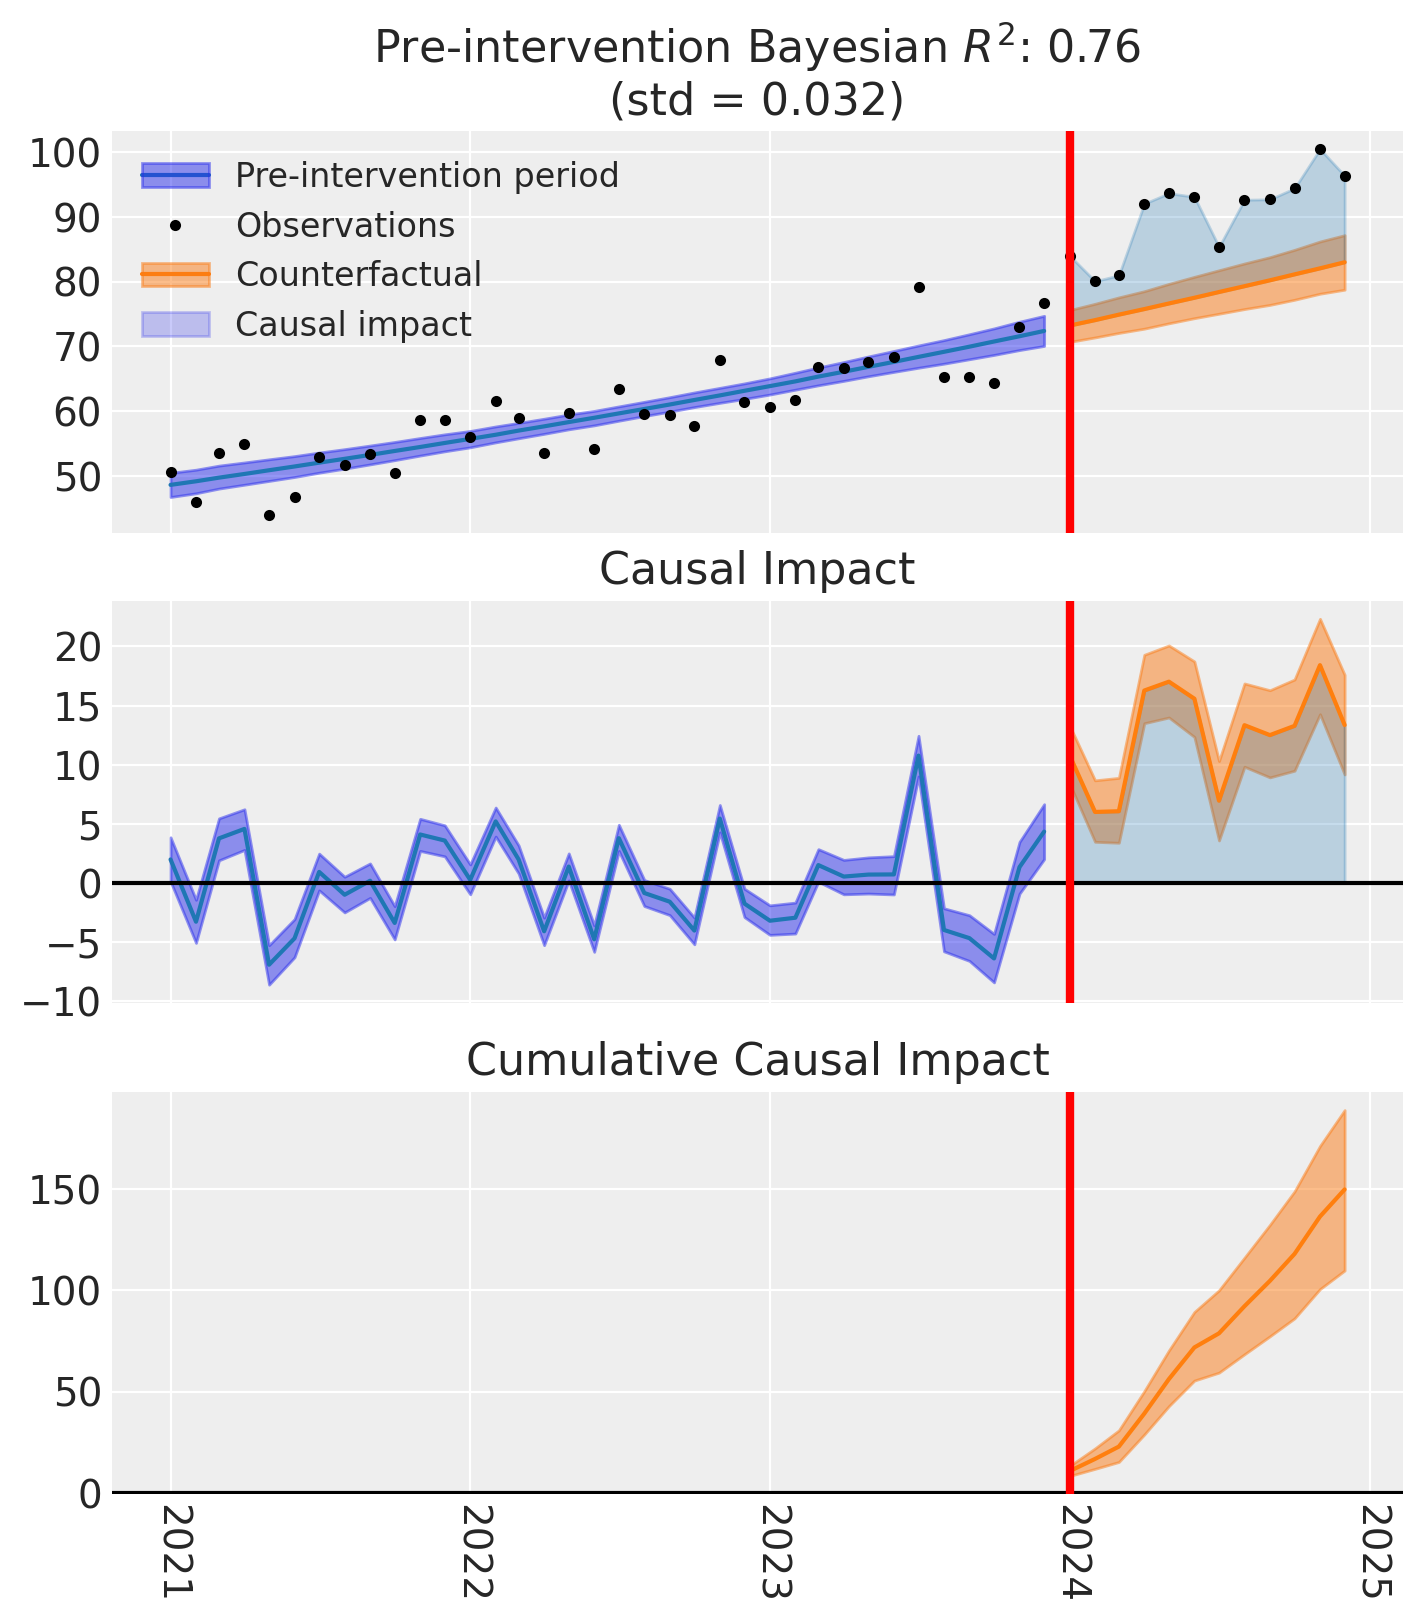

In [8]:
fig, axes = result.plot()

The custom model integrates seamlessly with CausalPy's experiment infrastructure — we get the same summary tables, causal impact plots, and cumulative effect estimates as with any built-in model.

## Common pitfalls

**Wrong variable names.** If you name your deterministic `"mean"` instead of `"mu"`, or your likelihood `"obs"` instead of `"y_hat"`, you will get a `KeyError` from `predict()` or `calculate_impact()`. Always use the names from the contract table above.

**Missing `with self:`.** Forgetting to wrap your model code in `with self:` means PyMC creates variables outside the model context. This leads to empty models that silently produce incorrect results during fitting.

**Prior scale mismatch.** When changing the mean function (e.g., log link), remember that coefficients operate on a different scale. The default `LinearRegression` priors assume identity-scale coefficients — these will be far too wide for a log-link model where coefficients represent log-scale changes.

**Missing `treated_units` coordinate.** The base class expects a `"treated_units"` dimension. If your data has a single unit, add a default:

```python
if coords is not None and "treated_units" not in coords:
    coords = coords.copy()
    coords["treated_units"] = ["unit_0"]
```